# Forecasting Australia's 2019 Election with PyMC3

<table style="float:right; width: 50%">
<tr><td> <img style="float: left; width: 100%" src="../img/mumbai.jpg"> </td></tr>
</table>

#### Martin Burgess
nousgroup.com

buckleysandnone.com

### Slides:
<b>buckleysandnone.com/pycon</b>

## Motivation
After my talk, I hope you will:
1. understand some the benefits of _probabilistic_ forecasting
2. see how easy it is to build probabilistic models using PyMC3

## Overview
1. Probabilistic forecasting
2. Defining the problem (Australian election primer)
3. Building a model in PyMC3

## Overview
1. Probabilistic forecasting <font color=grey>
2. Defining the problem (Australian election primer)
3. Building a model in PyMC3</font>

### What is probabilistic forecasting?

Rather than trying to identify the single most likely outcome, probabilistic forecasting tries to estimate the _relative probabilities of all possible outcomes_.

<table style="float:right; width: 50%">
<tr>
    <td> <img style="width: 100%" src="../img/weather.png"> </td>
    </tr>
</table> 
<br>
Most weather forecasts are probabilistic. 

Instead of just identifying the most likely outcome they forecast the relative probabilities of the two possible outomes (30% rain vs. 70% no rain). 


### Why forecast probabilistically? 
#### 1. The future is uncertain. 
<b>Sometimes something other than the _most likely_ outcome happens. </b>

<br>
Probabilistic forecasting can give you a really clear idea of uncertainty associated with your prediction. 


If we just forecast the most likley outcome, we don't have a clear sense of how much more likely it is than other outcomes. 
<table style="height:50%">
<tr>
    <td style="width: 25%"> <img style="float:right; width:100%" src="../img/newspoll-small.png"> </td> 
    <td style="width:10%; font-size:30px; text-align:center"> vs. </td>
    <td style="width: 65%"> <img style="float:left; width:100%" src="../img/buckleys.png"> </td>
    </tr>
</table>

### 2. Make better decisions

Use the probabilities you've generated to make decisions. 

<table style="width:50%">
<tr>
    <td style="width: 70%"> <img style="width:100%" src="../img/bet.png">     </tr>
</table>

In [1]:
(+230000*0.7) + (-1000000*0.3)

-139000.0

## Why forecast probabilistically?

1. The future is uncertain
2. Helps you make decisions
3. Assumptions are clear

## Overview
1. <font color=grey>Probabilistic forecasting </font>
2. Defining the problem (Australian election primer)
3. <font color=grey>Building a model in PyMC3</font>

### Who will win the 2019 Australian Federal election?

<b>Winner decided by the 151 seats in the House of Representatives</b>
<p style="color:#1c4f9c">Coalition win majority (>= 76 seats) </p>
<p style="color:#e53440">ALP win majority (>=76 seats)</p>
<p>Minority government (neither party wins 76 seats)</p>

<img src="../img/model-overview-seats2winner.svg">

### Use "two-party preferred" vote to predict seats

<table style="width:30%">
<tr>
    <td> <img style="width:100%" src="../img/ballot3.png"></td>
    </tr>
</table>

### TPP Margin = Coalition TPP - ALP TPP
<br>
<table style="width:40%">
    <tr>
        <th>Coalition TPP</th><th>ALP TPP</th><th>TPP Margin</th>
    </tr>
        <tr>
        <td>0.55</td><td>0.45</td><td>0.10</td>
    </tr>
        <tr>
        <td>0.475</td><td>0.525</td><td>-0.05</td>
    </tr>

<img src="../img/model-overview-full.svg">

In [2]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
import theano.tensor as tt
import arviz as az
sns.set(font_scale=1.7)
sns.set_style("white")
sns.despine()
# %matplotlib inline
final_ref_vals = {'alp_seats': 68,
            'lnc_seats': 76,
            'crossbench_total': 6,
            'tpp_margin': 0.03}

final_axes = {'alp_seats': (0,0),
        'lnc_seats': (0,1),
        'crossbench_total': (1,0),
        'tpp_margin': (1,1)}

In [3]:
%%html
<style>
td {font-size: 28px}
th {font-size: 30px}
</style>

In [4]:
polls = pd.read_csv('../data/polls2019.csv').drop(['next_election', 'days_to_next'], axis=1)
polls['tpp_adjusted'] = polls['tpp_margin'] -  polls['bias']
past_elections = pd.read_csv('../data/election_data.csv', index_col='date')
past_elections = past_elections.tail(22)
crossbench_stats = pd.read_csv('../data/crossbench_stats.csv', index_col=0)

In [5]:
with pm.Model() as full_model:
    p_retain = pm.Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = pm.Binomial('crossbench_retain_like', n=crossbench_stats['crossbench_running'], p=p_retain, observed=crossbench_stats['crossbench_retain'])
    crossbench_retain = pm.Binomial('crossbench_retain', n=6, p=p_retain)

    p_gain = pm.Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = pm.Binomial('crossbench_gain_like', n=crossbench_stats['gain_opportunities'], p=p_gain, observed=crossbench_stats['crossbench_gain'])
    crossbench_gain = pm.Binomial('crossbench_gain', n=145, p=p_gain)

    crossbench_total = pm.Deterministic('crossbench_total', crossbench_gain + crossbench_retain)

In [6]:
with full_model:
    # aggregate polls
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])

    #estimate relationship between tpp_margin and seat_margin
    slope = pm.Normal('slope', 0, sd=10) #prior
    intercept = pm.Normal('intercept', 0, sd=10) #prior
    error = pm.HalfCauchy('error', 1) #prior
    y = intercept + slope * past_elections['tpp_margin'] #define relationship
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = error, 
                              observed = past_elections['seat_margin_pc_majors']) #likelihood
    
    # combine tpp_margin estimate with our linear relationship
    seat_margin_pc = pm.Normal('seat_margin_pc', 
                               intercept + slope * tpp_margin, 
                               sd = error) #combine estimates
    # math
    majors_seats = (151.0 - crossbench_total)
    seat_margin_temp = majors_seats * seat_margin_pc
    lnc_seats = pm.Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))
    alp_seats = pm.Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))
    majors_seat_margin = pm.Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    
    trace = pm.sample(draws=5000,tune=1000, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [seat_margin_pc, error, intercept, slope, tpp_margin, p_gain, p_retain]
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:28<00:00, 421.83draws/s]
The number of effective samples is smaller than 25% for some parameters.


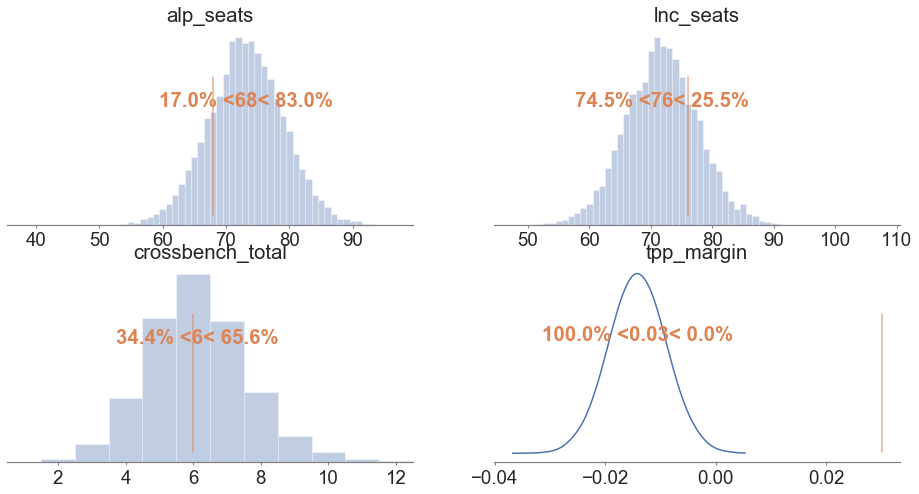

In [7]:
fig, ax = plt.subplots(2,2, figsize=[16,8])
for var in final_ref_vals:
    _ = az.plot_posterior(trace, var_names=var, point_estimate=None, credible_interval=None, ax=ax[final_axes[var]], round_to=2, ref_val=final_ref_vals[var])

Uncertainty:
- Polls
    - sampling error from small samples
    - other survey error
    - people changing their minds
- Translating polls to seats: "uniform swings" are not a thing

## Overview
1. <font color=grey>Probabilistic forecasting
2. Defining the problem (Australian election primer)</font>
3. Building a model in PyMC3

## Building a model in PyMC3

<img style="width:60%" src="../img/PyMC3_banner.svg">

In [8]:
import pymc3 as pm

### Bayesian Method
<img style="width:80%" src="../img/bayes.svg">

### Step One: Aggregate polls (bayesian parameter estimation)

<img src="../img/model-overview-2.svg">

#### Polls predicted a Labor victory

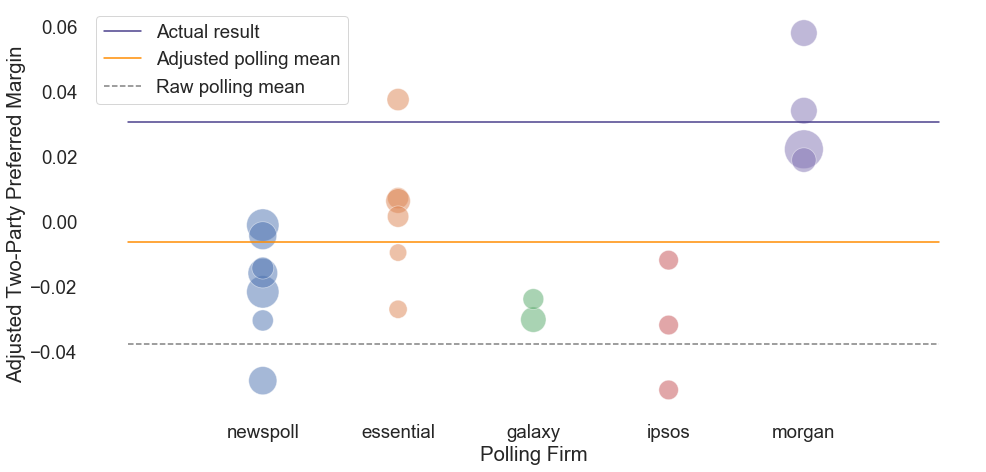

In [9]:
adjusted_mean = polls['tpp_adjusted'].mean()
raw_mean = polls['tpp_margin'].mean()
actual_result = (51.53-48.47)/100
fig, ax = plt.subplots(1,1,figsize=[16, 7.5])
_ = plt.plot([-1,5],[actual_result,actual_result],  color='darkslateblue', label='Actual result')
_ = plt.plot([-1,5],[adjusted_mean,adjusted_mean], color='darkorange', label='Adjusted polling mean')
_ = plt.plot([-1,5],[raw_mean,raw_mean], '--', color='grey', label='Raw polling mean')
_ = sns.scatterplot(x='firm', y='tpp_adjusted', size='std', hue='firm', sizes=(300,1500), alpha=0.5, legend=False, data=polls, ax=ax)
ax.set(xlabel = "Polling Firm", ylabel="Adjusted Two-Party Preferred Margin ")
sns.despine(left=True, bottom=True)
_ = ax.legend(loc = 'best')


<b>We are trying to combine these polls into a single _probabilistic_ estimate of the two-party preferred vote.</b>

#### What is the universe of possible two-party preferred margins?
<img style="width:80%" src="../img/prior.svg">

In [10]:
with pm.Model() as tpp_model:
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1)
    tpp_prior = pm.sample(draws=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tpp_margin]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 484.73draws/s]


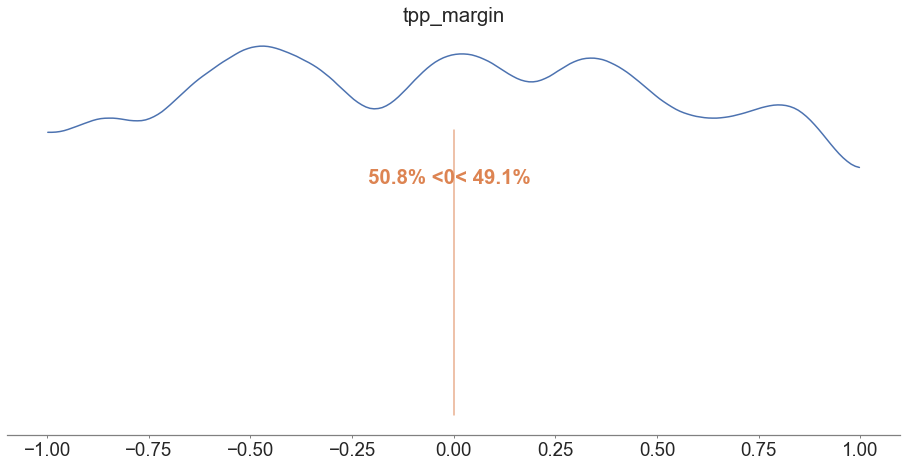

In [11]:
fig, ax = plt.subplots(1,1, figsize=[16, 7.5])
_ = az.plot_posterior(tpp_prior, credible_interval=None, point_estimate=None, ax=ax, ref_val=0)

- This is a probability density function.
- Along the x-axis are all the possible values of the two-party preferred margin. 
- The y-axis represents the relative probability of the different values
- You can see here that all values from -1 to 1 have similar probabilities because we haven't included any data in the model yet.

#### Specify a likelihood and add some data
<img style="width:80%" src="../img/bayes.svg">

In [12]:
with pm.Model() as tpp_model:
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])
    trace = pm.sample(draws=1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tpp_margin]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 423.02draws/s]
The acceptance probability does not match the target. It is 0.8880103016647556, but should be close to 0.8. Try to increase the number of tuning steps.


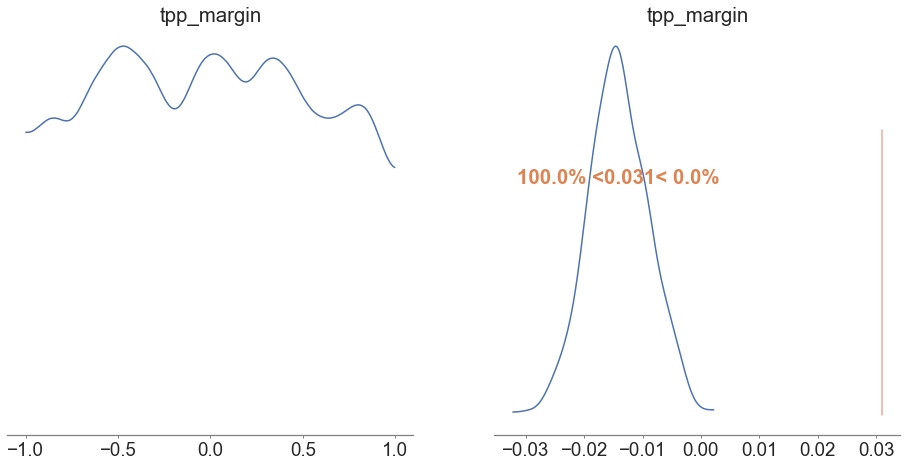

In [13]:
fig, ax = plt.subplots(1,2, figsize=[16, 7.5])
_ = az.plot_posterior(tpp_prior, credible_interval=None, point_estimate=None, ax=ax[0]) 
_ = az.plot_posterior(trace, credible_interval=None, point_estimate=None, ax=ax[1], round_to=2, ref_val=0.031)

<b>Can we take this shoddy estimate of the two-party preferred vote and still use it to forecast the election?</b>

### From the two-party preferred vote to the seats a party will win (Bayesian linear regression)

<img src="../img/model-overview-3.svg">

#### Look at the data: Historical election results

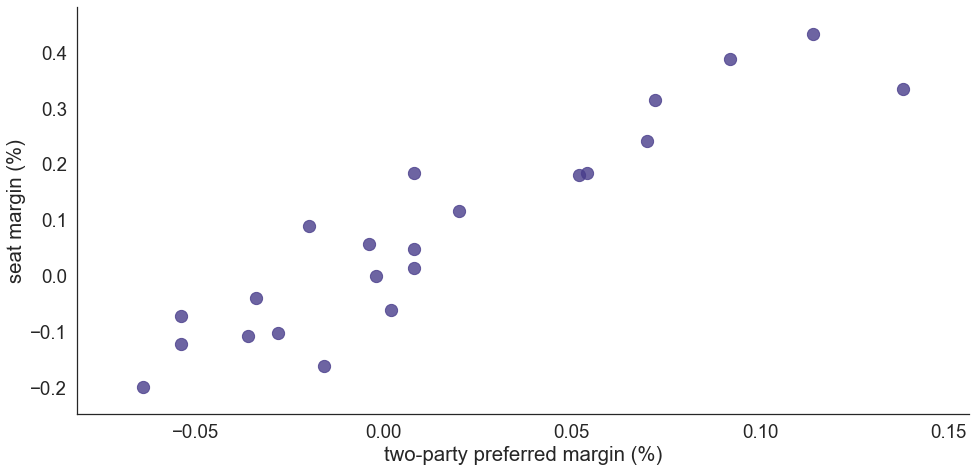

In [14]:
fig, ax = plt.subplots(1,1, figsize=[16,7.5])
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color="darkslateblue", s=150, alpha=0.8)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seat margin (%)")
sns.despine()

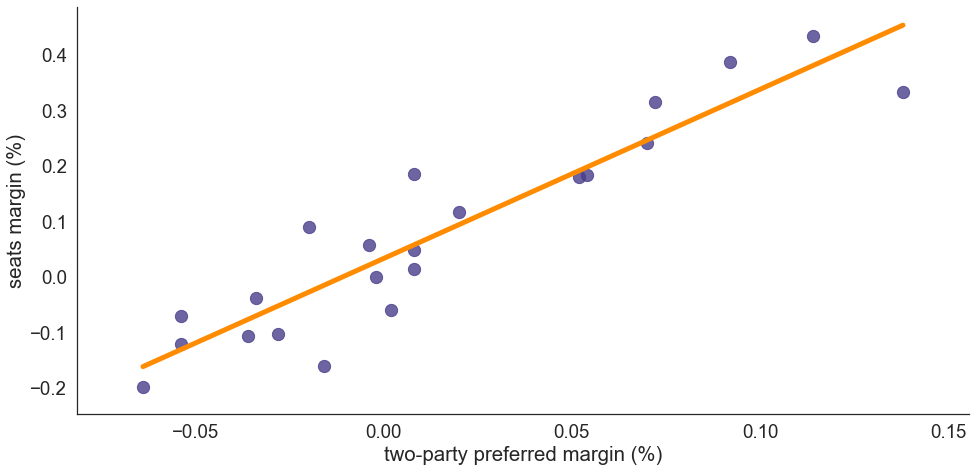

In [15]:
fig, ax = plt.subplots(1,1, figsize=[16,7.5])
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color="darkslateblue", s=150, alpha=0.8)
_ = plt.plot(np.unique(past_elections['tpp_margin']), np.poly1d(np.polyfit(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], 1))(np.unique(past_elections['tpp_margin'])),color="darkorange", linewidth=5)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")
sns.despine()

\begin{align}
\\y & = slope \times x +\ intercept\\
\\y & = 3.05 \times x +\ 0.03\\
\end{align}

#### Specify priors.
<img style="width:80%" src="../img/prior.svg">

In [16]:
with pm.Model() as linreg_model:
    slope = pm.Normal('slope', 0, sd=10)
    intercept = pm.Normal('intercept', 0, sd=10)
    error = pm.HalfCauchy('error', 1)
    linreg_priors = pm.sample(draws=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [error, intercept, slope]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 393.53draws/s]


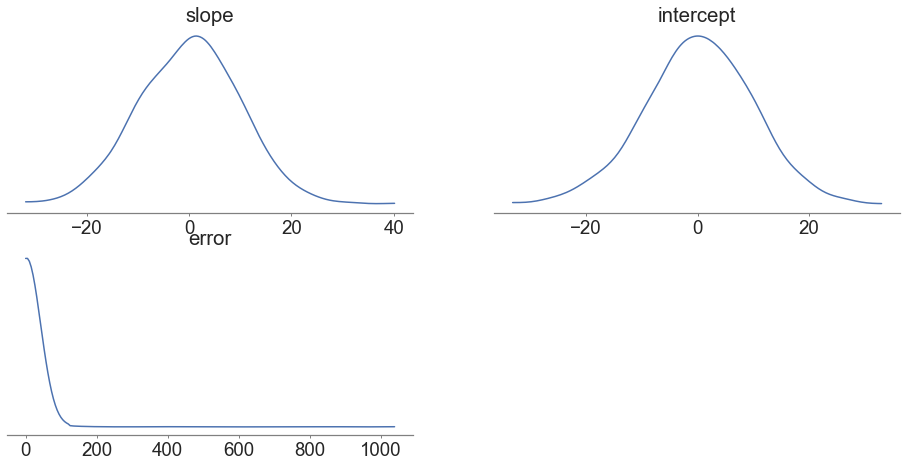

In [17]:
fig, ax = plt.subplots(2,2, figsize=[16,7.5])
_ = az.plot_posterior(linreg_priors, credible_interval=None, point_estimate=None, ax=ax)
ax[1,1].set_visible(False)

#### Specify likelihood.
<img style="width:80%" src="../img/bayes.svg">

In [18]:
with linreg_model:
    y = intercept + slope * past_elections['tpp_margin']
    # tpp2seat likelihood
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = error, 
                              observed = past_elections['seat_margin_pc_majors'])
    trace = pm.sample(draws=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [error, intercept, slope]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 323.59draws/s]


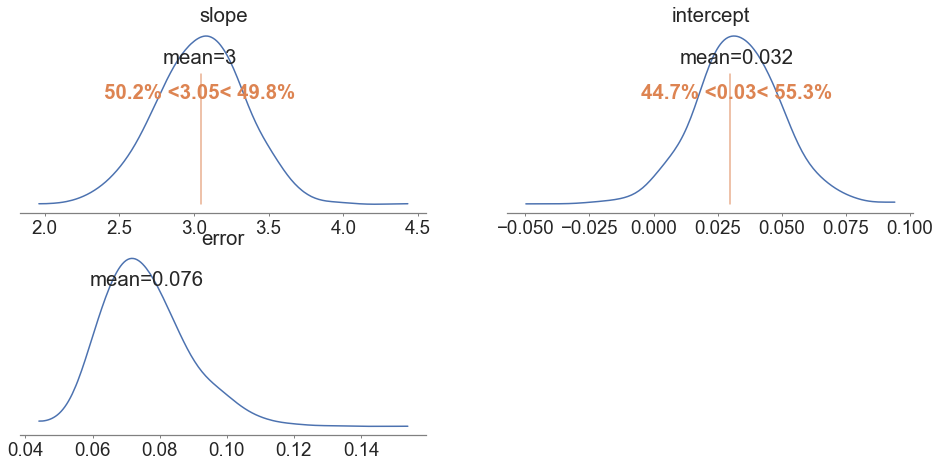

In [19]:
fig, ax = plt.subplots(2,2, figsize=[16,7.5]); ref_vals = {'slope': 3.05,'intercept': 0.03,'error': None}; axes = {'slope': (0,0),'intercept': (0,1),'error': (1,0)}
for var in ref_vals.keys():
    _ = az.plot_posterior(trace, var_names=var, credible_interval=None, ax=ax[axes[var]], round_to=2, ref_val=ref_vals[var])
ax[1,1].set_visible(False)

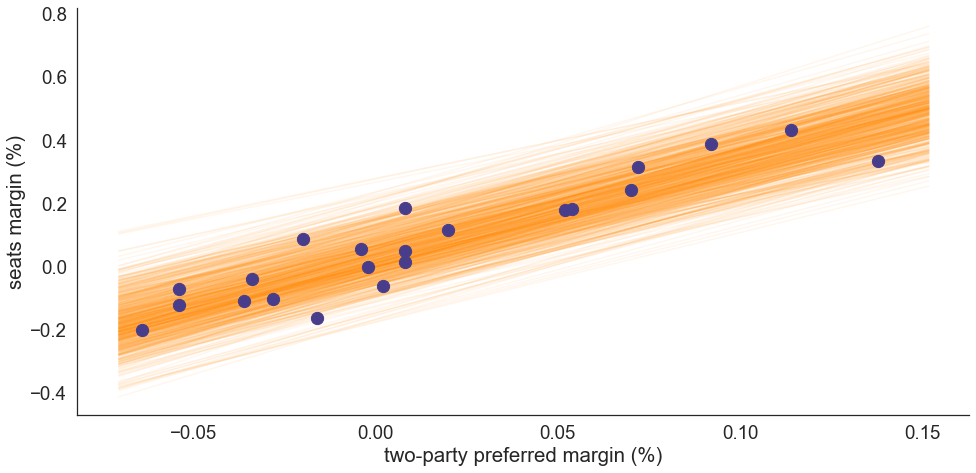

In [20]:
df = pm.trace_to_dataframe(trace)
fig, ax = plt.subplots(1,1, figsize=[16,7.5])
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color='darkslateblue', zorder=501, s=150)
for i in range(700):
    line_x = pd.DataFrame([past_elections['tpp_margin'].min()*1.1, past_elections['tpp_margin'].max()*1.1])
    line_y = line_x * df.loc[i,'slope'] + df.loc[i,'intercept'] + np.random.normal(loc=0.0, scale=df.loc[i,'error'])
    _ = plt.plot(line_x, line_y, color='darkorange', alpha=0.07, zorder=500-i)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")
sns.despine()

### Crossbench (homework)

In [21]:
with pm.Model() as all_together:
    p_retain = pm.Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = pm.Binomial('crossbench_retain_like', n=crossbench_stats['crossbench_running'], p=p_retain, observed=crossbench_stats['crossbench_retain'])
    crossbench_retain = pm.Binomial('crossbench_retain', n=6, p=p_retain)

    p_gain = pm.Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = pm.Binomial('crossbench_gain_like', n=crossbench_stats['gain_opportunities'], p=p_gain, observed=crossbench_stats['crossbench_gain'])
    crossbench_gain = pm.Binomial('crossbench_gain', n=145, p=p_gain)

    crossbench_total = pm.Deterministic('crossbench_total', crossbench_gain + crossbench_retain)

### Putting it all together

<img src="../img/model-overview-4.svg">

In [22]:
with all_together:
    # aggregate polls
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])

    #estimate relationship between tpp_margin and seat_margin
    slope = pm.Normal('slope', 0, sd=10) #prior
    intercept = pm.Normal('intercept', 0, sd=10) #prior
    error = pm.HalfCauchy('error', 1) #prior
    y = intercept + slope * past_elections['tpp_margin'] #define relationship
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = error, 
                              observed = past_elections['seat_margin_pc_majors']) #likelihood
    
    # combine tpp_margin estimate with our linear relationship
    seat_margin_pc = pm.Normal('seat_margin_pc', 
                               intercept + slope * tpp_margin, 
                               sd = error) #combine estimates
    
    majors_seats = (151.0 - crossbench_total)
    seat_margin_temp = majors_seats * seat_margin_pc
    lnc_seats = pm.Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))
    alp_seats = pm.Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))

    majors_seat_margin = pm.Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    trace = pm.sample(draws=5000,tune=1000, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [seat_margin_pc, error, intercept, slope, tpp_margin, p_gain, p_retain]
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 12000/12000 [00:24<00:00, 489.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


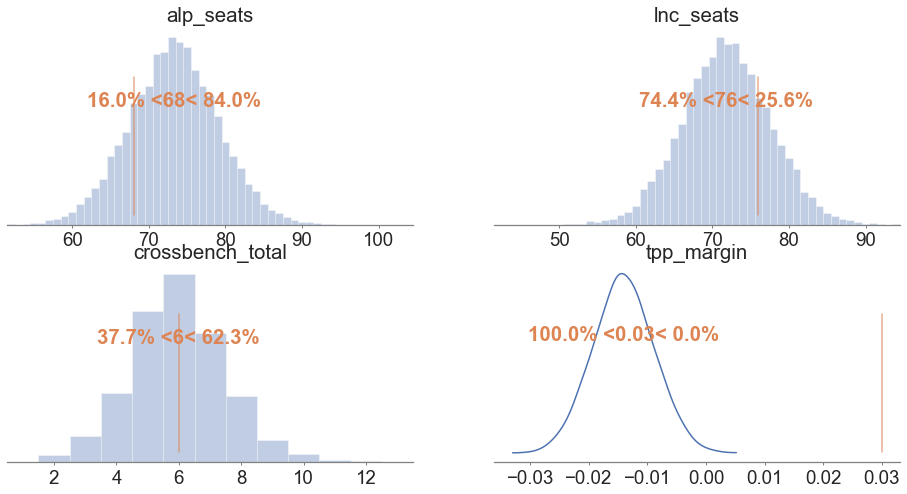

In [23]:
fig, ax = plt.subplots(2,2, figsize=[16,8])
for var in final_ref_vals:
    _ = az.plot_posterior(trace, var_names=var, point_estimate=None, credible_interval=None, ax=ax[final_axes[var]], round_to=2, ref_val=final_ref_vals[var])

## Who will win?
 <img src="../img/model-overview-full.svg">

In [24]:
print("Coalition win majority: {:.2f}%".format((trace['lnc_seats'] >= 76).mean()*100))
print("ALP win majority: {:.2f}%".format((trace['alp_seats'] >= 76).mean()*100))
print("Minority government (neither party wins absolute majority): {:.2f}%".format(((trace['lnc_seats'] <76 ) & (trace['alp_seats'] < 76)).mean()*100))

Coalition win majority: 25.64%
ALP win majority: 34.34%
Minority government (neither party wins absolute majority): 40.02%


Sometimes unlikely things happen. If you flip a coin twice and get heads both times, that's the same chance our forecast had of the Coalition winning the election. If we take an umbrella on a day with a 25% chace of rain, we should be surprised when the Coalition won. 

We can take a pretty crap estimate of the two-party preferred margin but because we estimate uncertainty in other parts of the model, our end result isn't too far off. 

We didn't "predict" the Coalition would win, we assigned 

# Thank you!

> Sometimes something other than the most likely outcome happens

## Free Resources

[ThinkBayes](https://greenteapress.com/wp/think-bayes/) by [Allen Downey](https://greenteapress.com/wp/think-bayes/)

[Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) by Cameron Davidson-Pilon

## Me

[buckleysandnone.com](https://www.buckleysandnone.com)

[twitter.com/martintburgess](https://twitter.com/martintburgess)

[nousgroup.com](https://www.nousgroup.com/)

 <img src="../img/buckley_homepage.png">